# Lista 6

Modelo CER de ativos correlacionados
1. Importar dados do Yahoo contendo a série histórica dos últimos 12 meses das
ações da Petrobrás, Vale, Ambev e Banco do Brasil.
2. Estime os parâmetros do modelo CER de cada um dos ativos
3. Verifique a sua normalidade
4. Calcule a matriz de correlação empirica entre esses ativos.
5. Compare os resultados da simulação MC do CER correlacionado com os respectivos dados históricos.
6. Estime os valores dos ativos em Dezembro/2024

## 1. Importar Dados do Yahoo Finance

- Utilizando a biblioteca quantmod para obter os dados históricos dos últimos 12 meses das ações da Petrobrás (PETR4.SA), Vale (VALE3.SA), Ambev (ABEV3.SA) e Banco do Brasil (BBAS3.SA).

### Instalar e carregar as bibliotecas necessárias

- [quantmod](https://www.quantmod.com)
  - Uso: Para importar dados financeiros históricos de várias fontes, incluindo Yahoo Finance. Utilizamos essa biblioteca para obter os preços ajustados das ações da Petrobrás, Vale, Ambev e Banco do Brasil.
- [tseries](https://uribo.github.io/rpkg_showcase/date_and_time/tseries.html)
  - Uso: Para realizar testes estatísticos. Utilizamos essa biblioteca para aplicar o teste de Jarque-Bera e verificar a normalidade dos retornos dos ativos.
- [PerformanceAnalytics](https://github.com/braverock/PerformanceAnalytics)
  - Uso: Para realizar análises de desempenho de investimentos. Utilizamos essa biblioteca para calcular retornos e realizar outras operações relacionadas a desempenho de ativos financeiros.
- [MASS](https://www.stats.ox.ac.uk/pub/MASS4/)
  - Uso: Para gerar amostras de distribuições multivariadas. Utilizamos essa biblioteca para simular retornos futuros dos ativos utilizando a matriz de covariância estimada.

In [61]:
install.packages("quantmod")
install.packages("tseries")
install.packages("PerformanceAnalytics")
install.packages("MASS")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [62]:
library(quantmod)
library(tseries)
library(PerformanceAnalytics)
library(MASS)

### Definir os símbolos dos ativos

In [63]:
simbolos <- c("PETR4.SA", "VALE3.SA", "ABEV3.SA", "BBAS3.SA")

### Obter os dados dos últimos 12 meses

- getSymbols: Esta é uma função do pacote quantmod que importa dados financeiros de várias fontes. quantmod significa "Quantitative Financial Modelling Framework".
- src = "yahoo": Este argumento define a fonte dos dados. "yahoo" indica que os dados serão importados do Yahoo Finance.
- from = Sys.Date() - 365: Este argumento define a data de início para a importação dos dados. Sys.Date() retorna a data atual, e Sys.Date() - 365 calcula a data exatamente um ano antes da data atual. Assim, os dados serão importados a partir de um ano atrás.
- to = Sys.Date(): Este argumento define a data final para a importação dos dados, que é a data atual (Sys.Date()).

### Resumindo

- Baixa os dados históricos para cada ativo, começando de Sys.Date() - 365 (um ano atrás) até Sys.Date() (data atual).
- Armazena os dados em objetos no seu ambiente de trabalho cada objeto terá o nome correspondente ao símbolo do ativo.

In [64]:
getSymbols(simbolos, src = "yahoo", from = Sys.Date() - 365, to = Sys.Date())

[1] "PETR4.SA" "VALE3.SA" "ABEV3.SA" "BBAS3.SA"

### Fechar os preços ajustados

- lapply é uma função que aplica uma função a cada elemento de uma lista ou vetor. Aqui, ela está aplicando a função anônima function(sym) Ad(get(sym)) a cada símbolo em simbolos.
- function(sym) Ad(get(sym)): Esta é uma função anônima que faz o seguinte para cada símbolo:
  - get(sym): Recupera o objeto correspondente ao símbolo sym do ambiente de trabalho. Por exemplo, se sym é "PETR4.SA", get("PETR4.SA") retorna o objeto PETR4.SA.
  - Ad(get(sym)): Ad é uma função do quantmod que extrai a coluna de preços ajustados (Adjusted Close) de um objeto de série temporal. O preço ajustado considera eventos corporativos como dividendos e splits de ações.
- O resultado de lapply é uma lista onde cada elemento é a série temporal dos preços ajustados para um dos símbolos.

- do.call(merge, ...):
  - do.call: Esta função executa uma função com argumentos especificados em uma lista. Aqui, ela está executando a função merge com os elementos da lista gerada por lapply como argumentos.
  - merge: Combina múltiplas séries temporais em uma única série temporal multivariada. Isso significa que as séries de preços ajustados de todos os símbolos serão combinadas em um único objeto, com uma coluna para cada símbolo.

### Resumo
- A linha de código combina as séries temporais de preços ajustados de todos os ativos especificados em simbolos em um único objeto de série temporal multivariada. Cada coluna do objeto resultante contém os preços ajustados para um dos ativos.

In [65]:
precos <- do.call(merge, lapply(simbolos, function(sym) Ad(get(sym))))

### Visualizar os dados

In [66]:
head(precos)

           PETR4.SA.Adjusted VALE3.SA.Adjusted ABEV3.SA.Adjusted
2023-05-30          21.40385          59.13878          13.76073
2023-05-31          21.18486          58.70638          13.69421
2023-06-01          21.86615          59.94840          13.53265
2023-06-02          22.04459          62.50605          13.74172
2023-06-05          22.27979          61.99084          13.69421
2023-06-06          22.75021          62.19324          14.08384
           BBAS3.SA.Adjusted
2023-05-30          21.00438
2023-05-31          20.96679
2023-06-01          21.02317
2023-06-02          21.33525
2023-06-05          21.46877
2023-06-06          21.71674

## 2. Estimar os Parâmetros do Modelo CER de Cada Ativo

- Primeiro, vamos calcular os retornos logarítmicos dos preços ajustados. Em seguida, estimamos a média e a variância desses retornos.

### Calcular retornos logarítmicos

- log(precos):
  - Aplica a função logarítmica natural a cada elemento da matriz precos. precos contém os preços ajustados dos ativos, e log(precos) calcula o logaritmo natural desses preços. O logaritmo natural é frequentemente usado em finanças para converter os preços em uma escala que facilita a análise de retornos.
- diff(log(precos)):
  - Calcula a diferença entre valores consecutivos de log(precos). Esta operação retorna uma matriz de retornos logarítmicos. Os retornos logarítmicos são uma forma comum de medir os retornos de ativos porque têm propriedades matemáticas úteis, como a aditividade ao longo do tempo.
- na.omit(...):
  - Remove quaisquer valores NA da matriz resultante. A função diff produz um NA na primeira posição porque não há valor anterior para calcular a diferença. na.omit remove essas linhas contendo NA, resultando em uma matriz de retornos logarítmicos sem valores faltantes.

### Resumo
- Esta linha de código calcula os retornos logarítmicos dos preços ajustados dos ativos e remove quaisquer valores NA resultantes do cálculo das diferenças.

In [67]:
retornos <- na.omit(diff(log(precos)))

### Função para identificar outliers usando o método IQR

In [68]:
identificar_outliers <- function(data) {
  outliers <- apply(data, 2, function(col) {
    Q1 <- quantile(col, 0.25)
    Q3 <- quantile(col, 0.75)
    IQR <- Q3 - Q1
    lower_bound <- Q1 - 1.5 * IQR
    upper_bound <- Q3 + 1.5 * IQR
    col < lower_bound | col > upper_bound
  })
  return(outliers)
}

### Função para tratar outliers (remover)

In [69]:
tratar_outliers <- function(data, outliers) {
  for (i in seq_len(ncol(data))) {
    data[outliers[, i], i] <- NA
  }
  return(na.omit(data))
}

  ### Identificar e tratar outliers

In [70]:
outliers <- identificar_outliers(retornos)

  ### Exibir os outliers identificados

In [71]:
cat("Outliers identificados:\n")
for (i in seq_len(ncol(retornos))) {
  outlier_indices <- which(outliers[, i])
    if (length(outlier_indices) > 0) {
      cat(colnames(retornos)[i], ":", outlier_indices, "\n")
    }
}

Outliers identificados:
PETR4.SA.Adjusted : 7 17 22 41 43 60 89 101 186 193 239 
VALE3.SA.Adjusted : 3 29 42 67 75 98 105 142 178 213 
ABEV3.SA.Adjusted : 5 26 29 37 46 105 107 126 127 128 136 187 234 
BBAS3.SA.Adjusted : 7 8 85 91 109 113 135 235 


### Visualizar os outliers com boxplot

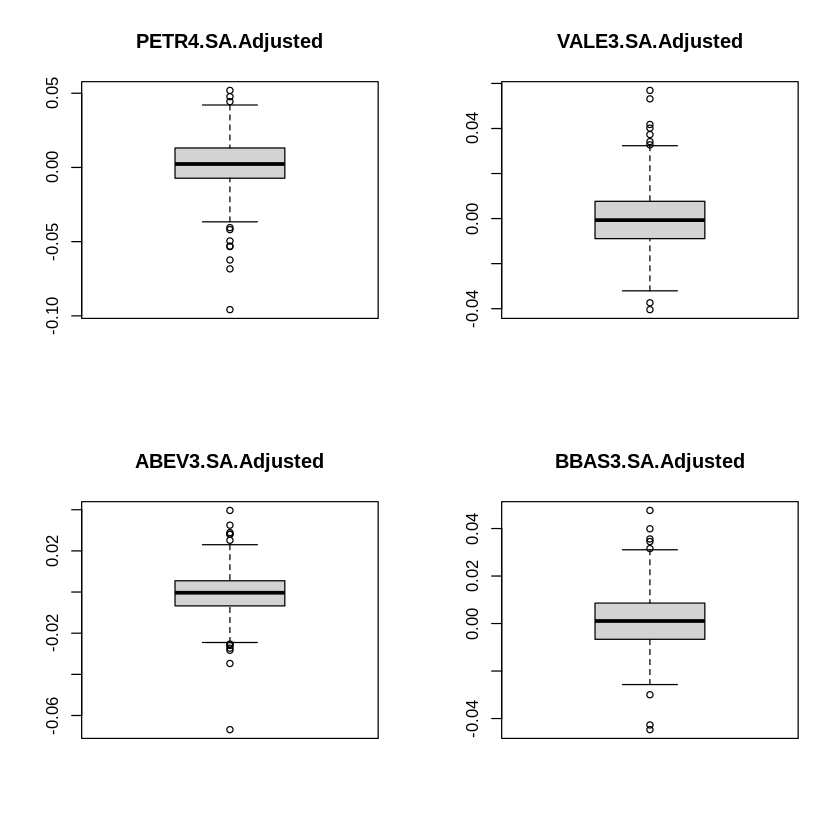

In [72]:
par(mfrow = c(2, 2))
for (i in seq_len(ncol(retornos))) {
  boxplot(retornos[, i], main = colnames(retornos)[i], outline = TRUE)
}

### Estimar os parâmetros do modelo CER

- colMeans(retornos):
  - Calcula a média de cada coluna na matriz retornos. retornos é uma matriz onde cada coluna representa os retornos logarítmicos de um ativo diferente.
  - colMeans retorna um vetor onde cada elemento é a média dos retornos para um ativo específico.
- cov(retornos):
  - Calcula a matriz de covariância dos retornos. A matriz de covariância descreve a variabilidade conjunta dos retornos dos ativos.
  - cov retorna uma matriz quadrada onde cada elemento (i, j) representa a covariância entre os retornos dos ativos i e j.

### Resumo
- Estas linhas de código calculam as médias dos retornos e a matriz de covariância dos retornos, que são parâmetros essenciais para a análise de portfólio e simulações financeiras.

In [73]:
retornos <- tratar_outliers(retornos, outliers)
medias <- colMeans(retornos)
cov_matrix <- cov(retornos)


### Visualizar os parâmetros estimados

In [74]:
medias
cov_matrix

PETR4.SA.Adjusted VALE3.SA.Adjusted ABEV3.SA.Adjusted BBAS3.SA.Adjusted 
     0.0032234117     -0.0009207974     -0.0008906110      0.0008568468

,PETR4.SA.Adjusted,VALE3.SA.Adjusted,ABEV3.SA.Adjusted,BBAS3.SA.Adjusted
PETR4.SA.Adjusted,2.105042e-04,3.405974e-05,-3.244165e-06,3.408108e-05
VALE3.SA.Adjusted,3.405974e-05,1.672757e-04,2.061143e-05,3.194790e-05
ABEV3.SA.Adjusted,-3.244165e-06,2.061143e-05,8.773650e-05,2.943518e-05
BBAS3.SA.Adjusted,3.408108e-05,3.194790e-05,2.943518e-05,1.151868e-04


## 3. Verificar a Normalidade

- Vamos utilizar o teste de Jarque-Bera para verificar a normalidade dos retornos.

### Testar normalidade dos retornos

- apply: A função apply aplica uma função a margens específicas de um array ou matriz. No caso de retornos, que é uma matriz, apply aplica a função a cada coluna ou linha.
- 2: O segundo argumento de apply especifica a margem ao longo da qual a função deve ser aplicada. 2 significa que a função será aplicada a cada coluna.
- jarque.bera.test: Esta é a função que será aplicada a cada coluna de retornos. A função jarque.bera.test realiza o teste de Jarque-Bera para avaliar a normalidade de uma distribuição.

In [75]:
retornos <- na.omit(diff(log(precos)))

In [76]:
testes_normalidade <- apply(retornos, 2, jarque.bera.test)

### Visualizar os resultados dos testes de normalidade

In [77]:
testes_normalidade

$PETR4.SA.Adjusted

	Jarque Bera Test

data:  newX[, i]
X-squared = 202.73, df = 2, p-value < 2.2e-16


$VALE3.SA.Adjusted

	Jarque Bera Test

data:  newX[, i]
X-squared = 26.123, df = 2, p-value = 2.125e-06


$ABEV3.SA.Adjusted

	Jarque Bera Test

data:  newX[, i]
X-squared = 125.89, df = 2, p-value < 2.2e-16


$BBAS3.SA.Adjusted

	Jarque Bera Test

data:  newX[, i]
X-squared = 19.217, df = 2, p-value = 6.716e-05



In [78]:
resultados <- sapply(testes_normalidade, function(teste) {
  if (teste$p.value > 0.05) {
    return("Distribuição normal")
  } else {
    return("Não é distribuição normal")
  }
})
return(resultados)

PETR4.SA.Adjusted           VALE3.SA.Adjusted 
"Não é distribuição normal" "Não é distribuição normal" 
          ABEV3.SA.Adjusted           BBAS3.SA.Adjusted 
"Não é distribuição normal" "Não é distribuição normal"

## 4. Calcular a Matriz de Correlação Empírica

- Vamos calcular a matriz de correlação entre os retornos dos ativos.

## Calcular matriz de correlação

In [79]:
cor_matrix <- cor(retornos)

### Visualizar matriz de correlação

In [80]:
cor_matrix

,PETR4.SA.Adjusted,VALE3.SA.Adjusted,ABEV3.SA.Adjusted,BBAS3.SA.Adjusted
PETR4.SA.Adjusted,1.000000000,0.20024552,-0.005389126,0.2839549
VALE3.SA.Adjusted,0.200245523,1.00000000,0.090892134,0.1658301
ABEV3.SA.Adjusted,-0.005389126,0.09089213,1.000000000,0.3685059
BBAS3.SA.Adjusted,0.283954853,0.16583007,0.368505896,1.0000000


## 5. Comparar Resultados da Simulação MC do CER Correlacionado com Dados Históricos

- Vamos simular os retornos dos ativos utilizando a matriz de correlação e comparar os resultados com os dados históricos.

### Número de simulações

In [81]:
numero_simulacoes <- 10000
numeros_ativos <- ncol(retornos)
numero_periodos <- nrow(retornos)

### Simular retornos futuros usando Monte Carlo

In [82]:
set.seed(123)
retornos_simulados <- mvrnorm(numero_simulacoes * numero_periodos,
                              mu = medias, Sigma = cov_matrix)
retornos_simulados <- matrix(retornos_simulados,
                             ncol = numeros_ativos, byrow = TRUE)

### Comparar os retornos simulados com os retornos históricos

In [83]:
media_simulada <- colMeans(retornos_simulados)
simulada_cov_matrix <- cov(retornos_simulados)

### Visualizar comparação

In [84]:
list(
  MediaHistorica = medias,
  MediaSimulada = media_simulada,
  CovarianciaHistorica = cov_matrix,
  CovarianciaSimulada = simulada_cov_matrix
)

$MediaHistorica
PETR4.SA.Adjusted VALE3.SA.Adjusted ABEV3.SA.Adjusted BBAS3.SA.Adjusted 
     0.0032234117     -0.0009207974     -0.0008906110      0.0008568468 

$MediaSimulada
[1] 0.0005642598 0.0005695478 0.0005566068 0.0005620177

$CovarianciaHistorica
                  PETR4.SA.Adjusted VALE3.SA.Adjusted ABEV3.SA.Adjusted
PETR4.SA.Adjusted      2.105042e-04      3.405974e-05     -3.244165e-06
VALE3.SA.Adjusted      3.405974e-05      1.672757e-04      2.061143e-05
ABEV3.SA.Adjusted     -3.244165e-06      2.061143e-05      8.773650e-05
BBAS3.SA.Adjusted      3.408108e-05      3.194790e-05      2.943518e-05
                  BBAS3.SA.Adjusted
PETR4.SA.Adjusted      3.408108e-05
VALE3.SA.Adjusted      3.194790e-05
ABEV3.SA.Adjusted      2.943518e-05
BBAS3.SA.Adjusted      1.151868e-04

$CovarianciaSimulada
             [,1]         [,2]         [,3]         [,4]
[1,] 1.480104e-04 2.943661e-06 2.887891e-06 2.732655e-06
[2,] 2.943661e-06 1.481427e-04 2.797865e-06 2.870482e-06
[3,] 2.887891e-06 2.797865e-06 1.480120e-04 2.686859e-06
[4,] 2.732655e-06 2.870482e-06 2.686859e-06 1.480353e-04

## 6. Estimar Valores dos Ativos em Dezembro/2024

- Vamos projetar os preços dos ativos para dezembro de 2024 utilizando os parâmetros estimados.

### Período de projeção (restante do ano)

In [85]:
periodo_projetado <- as.integer(difftime(as.Date("2024-12-31"), Sys.Date(), units = "days"))

### Estimar valores futuros usando a média e covariância dos retornos

In [86]:
precos_simulados <- matrix(0, nrow = numero_simulacoes, ncol = numeros_ativos)
precos_atuais <- tail(precos, 1)

In [87]:
for (i in 1:numero_simulacoes) {
  retornos_futuros <- mvrnorm(periodo_projetado, mu = medias / 252, Sigma = cov_matrix / 252)
  retornos_futuros_cum <- apply(retornos_futuros, 2, cumsum)
  precos_simulados[i, ] <- precos_atuais * exp(tail(retornos_futuros_cum, 1))
}

### Estimar os valores médios futuros em dezembro/2024

In [88]:
precos_futuros_estimados <- colMeans(precos_simulados)

### Visualizar os valores estimados

In [89]:
data.frame(
  Ativos = simbolos,
  PrecoAtuais = as.numeric(precos_atuais),
  Preco_Futuro_Estimado = precos_futuros_estimados
)

Ativos,PrecoAtuais,Preco_Futuro_Estimado
<chr>,<dbl>,<dbl>
PETR4.SA,37.80,37.90583
VALE3.SA,63.89,63.83964
ABEV3.SA,11.59,11.58119
BBAS3.SA,27.32,27.34189
